In [1]:
import matplotlib.pyplot as plt
import tss
import numpy as np
import ark

This notebook is meant as a companion notebook to Section 4 of the TSS paper. The purpose is to allow the user to follow along with some of the experiments in the paper, as well as illustrate additional features that were omitted for brevity.

We will  study the following Gaussian model. 
$$ \rho_\lambda(x) = \frac{1}{\sqrt{2\pi}} e^{-(x-\lambda)^2 / 2}. $$
We take $\Lambda = [0, K-1]$ for some integer $K \geq 1$, and we use the discretization $\lambda_k = k / (K-1).$ 

In [2]:
# convenience functions; skip ahead for plots

from matplotlib.ticker import MaxNLocator
get_traj_key = lambda traj, key : np.array([t[key] for t in traj]).squeeze()

def make_graph(number_of_rungs, window_size, single_window):
    max_dist = number_of_rungs - 1
    gb = tss.GraphBuilder()
    edge_id = gb.add_edge(node_array = ['left', 'right'], number_of_rungs = [number_of_rungs], window_size = [window_size], primary_window_tiling_only=single_window)
    gb.add_schedule(edge_id, group_name = "mean_0", interpolation = "linear", bounds=[0, max_dist])
    graph = gb.build()
    return graph

def run_setup(name, graph, parameters, nsteps=int(1e6), write_interval=int(1e3)):
    sim = tss.Gaussian(graph, **parameters, directory=name)
    with sim.launch():
        sim.step(nsteps, write=True, write_interval=write_interval,)
    traj = sim.trajectory()
    return traj

def plot_empirical_rung_distribution(traj):
    rungs = get_traj_key(traj, 'TSS_rung_before')
    plt.title('Empirical rung distribution')
    plt.xlabel('Rung index')
    plt.ylabel('Frequency')
    plt.hist(rungs, density=True)

def plot_rung_traj(time, traj):
    rungs = get_traj_key(traj, 'TSS_rung_before')
    plt.title('Rung trajectory')
    plt.xlabel('# steps (subsampled)')
    plt.ylabel('Rung index')
    plt.plot(time, rungs, '.')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    
def plot_final_free_energies(traj):
    fes =  get_traj_key(traj, 'TSS_FE')
    plt.title('Free energy landscape')
    plt.xlabel('Rung index')
    plt.ylabel('Free energy')    
    plt.plot(fes[-1] - fes[-1,0])
    
def plot_free_energy_traj(time, traj, errbars=False, idx0=0, color='C0', label=None):
    fes =  get_traj_key(traj, 'TSS_FE')
    df = fes[:, -1] - fes[:, 0]
    plt.title('End-to-end free energy trajectory')
    plt.xlabel('# steps (subsampled)')
    plt.ylabel('Free energy difference')
    
    plt.plot(time[idx0:], df[idx0:], color)
    if(errbars):
        errs = get_traj_key(traj, 'TSS_PairErrors')[idx0:]
        plt.fill_between(time[idx0:], -2*errs, 2*errs, color=color, alpha=0.4, label=label)


# No visit control

We demonstrate the exponential slowdown that occurs when no visit control is present, as discussed in Section 3. 

In [20]:
# setup the parameters used for the simulation
# only the graphs differ
graph1 = make_graph(5, 5, True)
graph2 = make_graph(10, 10, True)
parameters = {'alpha' : 0.0, 'visit_control_eta' : 0.0, 'moves_per_estimator_update' : 1}
# The default number of steps to run with is 1e6,
# while the default write interval is 1e3;
# this defines the length of our "time" axis
# as well as its spacing.
time = np.linspace(0, int(1e6)-1, int(1e3))

In [4]:
# run the simulations 
# (warning: this may take several minutes)
traj1 = run_setup('rungs5_windows1', graph1, parameters)
traj2 = run_setup('rungs10_windows1', graph2, parameters)

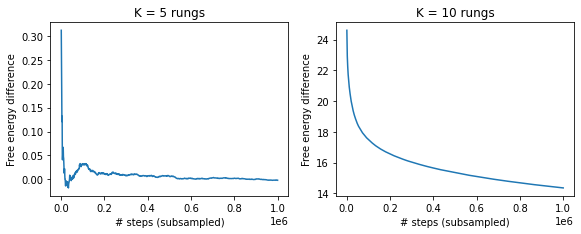

In [5]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj1)
plt.title('K = 5 rungs')
plt.subplot(1,2,2)
plot_free_energy_traj(time, traj2)
plt.title('K = 10 rungs');

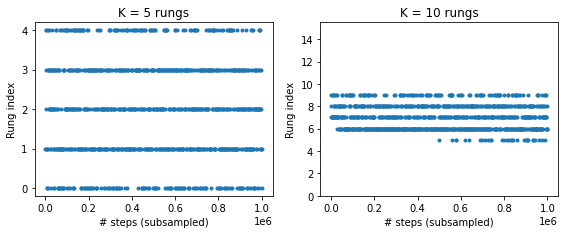

In [6]:
# plot the rung trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_rung_traj(time, traj1)
plt.title('K = 5 rungs')
plt.subplot(1,2,2)
plot_rung_traj(time, traj2)
plt.gca().set_ylim([0, 15.5])
plt.title('K = 10 rungs');

The rung plots above illustrate that the rung sampling becomes trapped for $K = 10$. The behavior of the rung process is closely tied to the behavior of the free energy difference estimates, which suffer from an exponential slowdown for $K=10$. 

# History forgetting

History forgetting was not explored in the main paper, but is an important aspect of the algorithm for practical problems. In traditional Monte Carlo, a certain percentage of the initial frames are dropped. History forgetting is the on-the-fly version of this procedure, and $\alpha$ denotes the percentage of frames that are "forgotten". Below, we illustrate the effect of the history forgetting in the setting of this Gaussian example. 

In [7]:
# set the 'alpha' and 'epoch_count' parameters,
# as discussed in the Supplementary Materials,
# Section 6.3
graph3 = make_graph(15, 15, True)
parameters1 = {'alpha' : 0.19, 
                'epoch_count' : 32, 
                'visit_control_eta' : 0.0, 
                'moves_per_estimator_update' : 1}

In [8]:
traj3 = run_setup('rungs15_windows1_alpha0.19', graph3, parameters1)

Text(0.5, 1.0, 'K = 15 rungs')

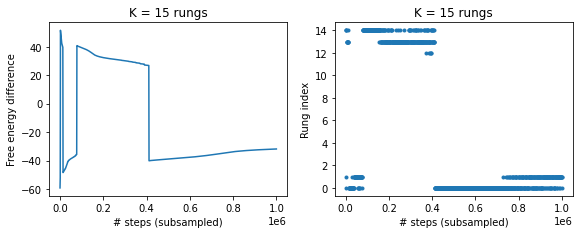

In [9]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_free_energy_traj(time, traj3)
plt.title('K = 15 rungs')
plt.subplot(1,2,2)
plot_rung_traj(time, traj3)
plt.title('K = 15 rungs')

# With visit control

Now we return to the problem of handling the exponential slowdown, which TSS accomplishes through the visit control mechanism.

In [10]:
graph4 = make_graph(50, 50, True)
graph5 = make_graph(100, 100, True)
parameters2 = {'alpha' : 0.19,                 
               'epoch_count' : 32,
               'visit_control_eta' : 2.0, 
               'moves_per_estimator_update' : 1}
# We run the system with 50 and 100 rungs for a smaller number of steps
# so that the simulation completes in a reasonable amount of time.
# To match Section 4 of the paper, one should run with int(1e6) steps.
time1 = np.linspace(0, int(1e5)-1, int(1e2))

In [11]:
traj4 = run_setup('rungs50_windows1_alpha0.19_eta2.0', graph4, parameters2, nsteps=int(1e5), write_interval=int(1e3))
traj5 = run_setup('rungs100_windows1_alpha0.19_eta2.0', graph5, parameters2, nsteps=int(1e5), write_interval=int(1e3))

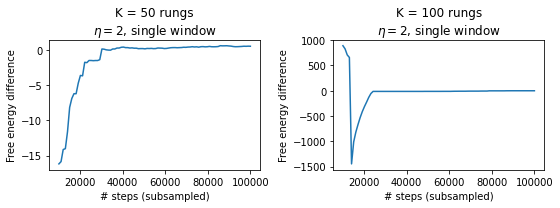

In [12]:
# plot the free energy trajectories
fig, ax = plt.subplots(figsize=(8, 3))
fig.tight_layout()
plt.subplot(1,2,1)
plot_free_energy_traj(time1, traj4, idx0=10)
plt.title('K = 50 rungs\n$\eta=2$, single window')
plt.subplot(1,2,2)
plot_free_energy_traj(time1, traj5, idx0=10)
plt.title('K = 100 rungs\n$\eta=2$, single window')
plt.tight_layout()

As mentioned in Section 4, visit control alleviates the exponential slowdown of the free energy difference estimates, but may still suffer from a polynomial slowdown. In the simulations above we used $10^5$ steps instead of the $10^6$ used in the paper. The user can explore these simulations further by extending the simulation time. The convenience functions defined at the beginning of the notebook also produce plots with additional information.

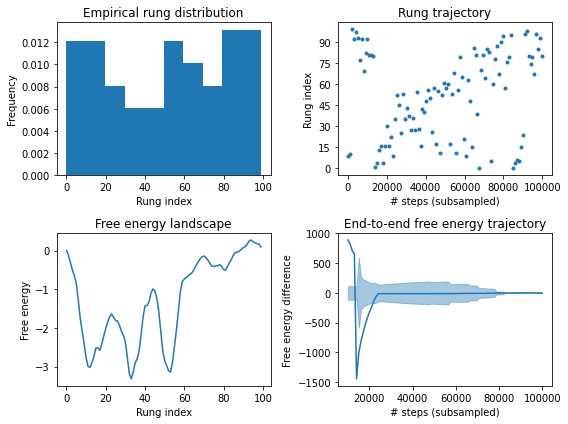

In [13]:
# set trajectory, traj = traj4 or traj5
traj = traj5
plt.subplots(figsize=(8,6))
plt.subplot(2,2,1)
plot_empirical_rung_distribution(traj)
plt.subplot(2,2,2)
plot_rung_traj(time1, traj)
plt.subplot(2,2,3)
plot_final_free_energies(traj)
plt.subplot(2,2,4)
plot_free_energy_traj(time1, traj, errbars=True, idx0=10)
plt.tight_layout()

# Windows

Windows allow one to extend the good behavior of a single-window simulation with visit control to arbitrarily large values of $K$.

In [14]:
# the second argument to make_graph defines the window size
graph6 = make_graph(100, 10, False) 
print('There are {} windows.'.format(len(graph6['graph.windows'])))

There are 21 windows.


In [15]:
traj6 = run_setup('rungs100_windows21_alpha0.19_eta2.0', graph6, parameters2, nsteps=int(1e5), write_interval=int(1e3))

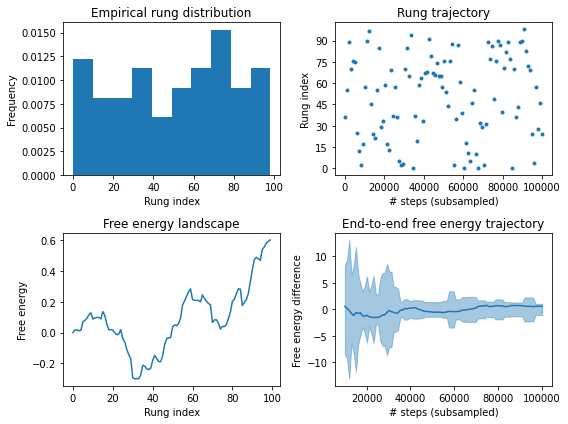

In [16]:
traj = traj6
plt.subplots(figsize=(8,6))
plt.subplot(2,2,1)
plot_empirical_rung_distribution(traj)
plt.subplot(2,2,2)
plot_rung_traj(time1, traj)
plt.subplot(2,2,3)
plot_final_free_energies(traj)
plt.subplot(2,2,4)
plot_free_energy_traj(time1, traj, errbars=True, idx0=10)
plt.tight_layout()

# Self-adjustment

Self-adjustment relies on increasing the number of moves per estimators update, denoted by $\nu$ in the paper and below. In the plots below, both trajectories have the same number of estimator updates, but the samples with $\nu = 32$ have a rung distribution that is closer to the density $p_{\pi,F}^{[K]}(k) \propto \pi_k \exp(F_k - F_k^\star)$. 

In [17]:
parameters3 = {'alpha' : 0.19, 
                'epoch_count' : 32, 
                'visit_control_eta' : 2.0, 
                'moves_per_estimator_update' : 32}

In [18]:
traj7 = run_setup('rungs50_windows1_alpha0.19_eta4.0_mpeu32', graph4, parameters3, 
                  nsteps=32*int(1e5), write_interval=32*int(1e3))

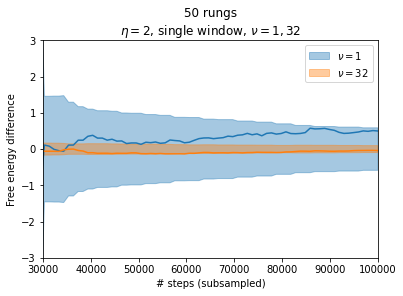

In [19]:
# plot the free energy trajectories
plot_free_energy_traj(time1, traj4, errbars=True, idx0=10, label=r'$\nu = 1$')
plot_free_energy_traj(time1, traj7, errbars=True, idx0=10, color='C1', label=r'$\nu = 32$')
plt.axis([3e4, 1e5, -3, 3])
plt.title('50 rungs\n$\eta=2$, single window, '+r'$\nu = 1, 32$')
plt.legend()
